# Trains a diffusion model on CIFAR-10 (version 2).

By Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings).

The model is a denoising diffusion probabilistic model (https://arxiv.org/abs/2006.11239), which is trained to reverse a gradual noising process, allowing the model to generate samples from the learned data distribution starting from random noise. DDIM-style deterministic sampling (https://arxiv.org/abs/2010.02502) is also supported. This model is also trained on continuous timesteps parameterized by the log SNR on each timestep (see Variational Diffusion Models, https://arxiv.org/abs/2107.00630), allowing different noise schedules than the one used during training to be easily used during sampling. It uses the 'v' objective from Progressive Distillation for Fast Sampling of Diffusion Models (https://openreview.net/forum?id=TIdIXIpzhoI) for better conditioned denoised images at high noise levels, but reweights the loss function so that it has the same relative weighting as the 'eps' objective.

In [1]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [2]:
# Check the GPU type

!nvidia-smi

Thu Apr 27 16:26:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    48W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Imports

from contextlib import contextmanager
from copy import deepcopy
import math

from IPython import display
from matplotlib import pyplot as plt
import torch
from torch import optim, nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import datasets, transforms, utils
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm, trange


In [4]:
# Utilities

@contextmanager
def train_mode(model, mode=True):
    """A context manager that places a model into training mode and restores
    the previous mode on exit."""
    modes = [module.training for module in model.modules()]
    try:
        yield model.train(mode)
    finally:
        for i, module in enumerate(model.modules()):
            module.training = modes[i]


def eval_mode(model):
    """A context manager that places a model into evaluation mode and restores
    the previous mode on exit."""
    return train_mode(model, False)


@torch.no_grad()
def ema_update(model, averaged_model, decay):
    """Incorporates updated model parameters into an exponential moving averaged
    version of a model. It should be called after each optimizer step."""
    model_params = dict(model.named_parameters())
    averaged_params = dict(averaged_model.named_parameters())
    assert model_params.keys() == averaged_params.keys()

    for name, param in model_params.items():
        averaged_params[name].mul_(decay).add_(param, alpha=1 - decay)

    model_buffers = dict(model.named_buffers())
    averaged_buffers = dict(averaged_model.named_buffers())
    assert model_buffers.keys() == averaged_buffers.keys()

    for name, buf in model_buffers.items():
        averaged_buffers[name].copy_(buf)


In [5]:
# Define the model (a residual U-Net)

class ResidualBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return self.main(input) + self.skip(input)


class ResConvBlock(ResidualBlock):
    def __init__(self, c_in, c_mid, c_out, dropout_last=True):
        skip = None if c_in == c_out else nn.Conv2d(c_in, c_out, 1, bias=False)
        super().__init__([
            nn.Conv2d(c_in, c_mid, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(c_mid, c_out, 3, padding=1),
            nn.Dropout2d(0.1, inplace=True) if dropout_last else nn.Identity(),
            nn.ReLU(inplace=True),
        ], skip)


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])


class Diffusion(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        # The inputs to timestep_embed will approximately fall into the range
        # -10 to 10, so use std 0.2 for the Fourier Features.
        self.timestep_embed = FourierFeatures(1, 16, std=0.2)
        self.class_embed = nn.Embedding(10, 4)

        self.net = nn.Sequential(   # 32x32
            ResConvBlock(3 + 16 + 4, c, c),
            ResConvBlock(c, c, c),
            SkipBlock([
                nn.AvgPool2d(2),  # 32x32 -> 16x16
                ResConvBlock(c, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),  # 16x16 -> 8x8
                    ResConvBlock(c * 2, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),  # 8x8 -> 4x4
                        ResConvBlock(c * 4, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 8),
                        ResConvBlock(c * 8, c * 8, c * 4),
                        nn.Upsample(scale_factor=2),
                    ]),  # 4x4 -> 8x8
                    ResConvBlock(c * 8, c * 4, c * 4),
                    ResConvBlock(c * 4, c * 4, c * 2),
                    nn.Upsample(scale_factor=2),
                ]),  # 8x8 -> 16x16
                ResConvBlock(c * 4, c * 2, c * 2),
                ResConvBlock(c * 2, c * 2, c),
                nn.Upsample(scale_factor=2),
            ]),  # 16x16 -> 32x32
            ResConvBlock(c * 2, c, c),
            ResConvBlock(c, c, 3, dropout_last=False),
        )

    def forward(self, input, log_snrs, cond):
        timestep_embed = expand_to_planes(self.timestep_embed(log_snrs[:, None]), input.shape)
        class_embed = expand_to_planes(self.class_embed(cond), input.shape)
        return self.net(torch.cat([input, class_embed, timestep_embed], dim=1))


In [6]:
# Define the noise schedule and sampling loop

def get_alphas_sigmas(log_snrs):
    """Returns the scaling factors for the clean image (alpha) and for the
    noise (sigma), given the log SNR for a timestep."""
    return log_snrs.sigmoid().sqrt(), log_snrs.neg().sigmoid().sqrt()


def get_ddpm_schedule(t):
    """Returns log SNRs for the noise schedule from the DDPM paper."""
    return -torch.special.expm1(1e-4 + 10 * t**2).log()


@torch.no_grad()
def sample(model, x, steps, eta, classes):
    """Draws samples from a model given starting noise."""
    ts = x.new_ones([x.shape[0]])

    # Create the noise schedule
    t = torch.linspace(1, 0, steps + 1)[:-1]
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)

    # The sampling loop
    for i in trange(steps):

        # Get the model output (v, the predicted velocity)
        with torch.cuda.amp.autocast():
            v = model(x, ts * log_snrs[i], classes).float()

        # Predict the noise and the denoised image
        pred = x * alphas[i] - v * sigmas[i]
        eps = x * sigmas[i] + v * alphas[i]

        # If we are not on the last timestep, compute the noisy image for the
        # next timestep.
        if i < steps - 1:
            # If eta > 0, adjust the scaling factor for the predicted noise
            # downward according to the amount of additional noise to add
            ddim_sigma = eta * (sigmas[i + 1]**2 / sigmas[i]**2).sqrt() * \
                (1 - alphas[i]**2 / alphas[i + 1]**2).sqrt()
            adjusted_sigma = (sigmas[i + 1]**2 - ddim_sigma**2).sqrt()

            # Recombine the predicted noise and predicted denoised image in the
            # correct proportions for the next step
            x = pred * alphas[i + 1] + eps * adjusted_sigma

            # Add the correct amount of fresh noise
            if eta:
                x += torch.randn_like(x) * ddim_sigma

    # If we are on the last timestep, output the denoised image
    return pred


The noise schedule:


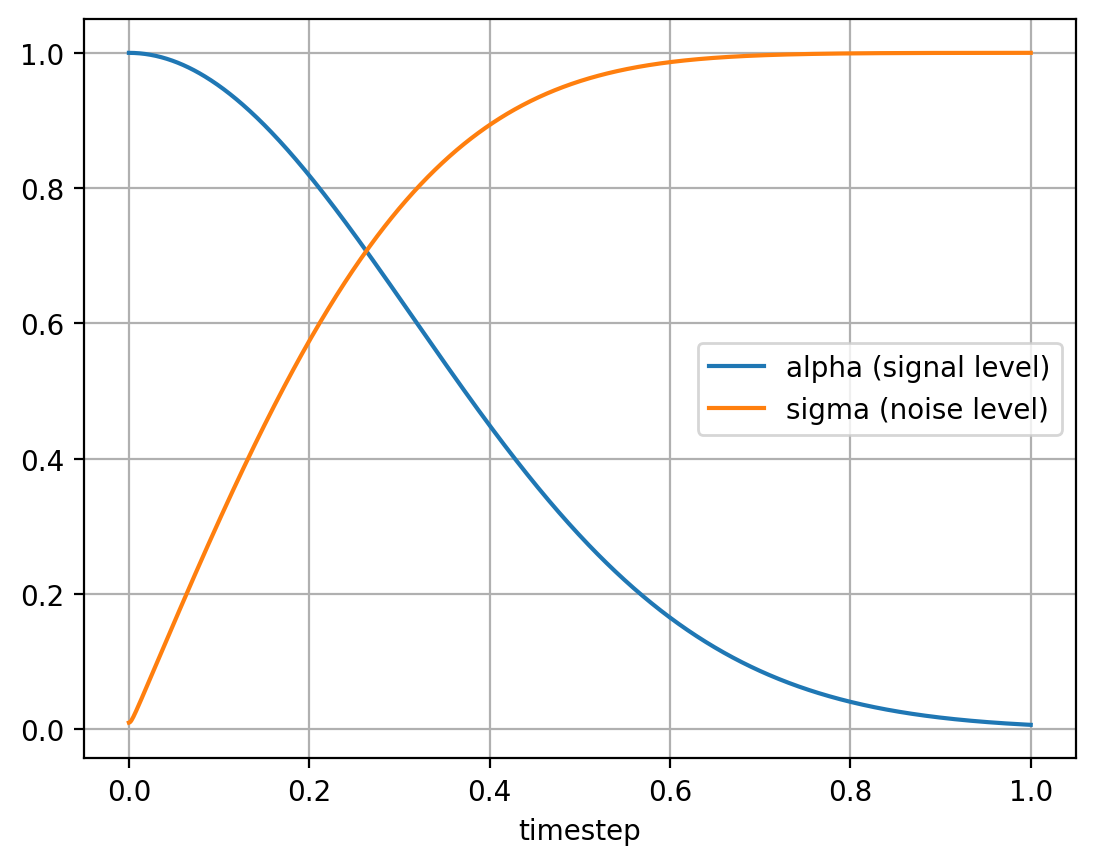

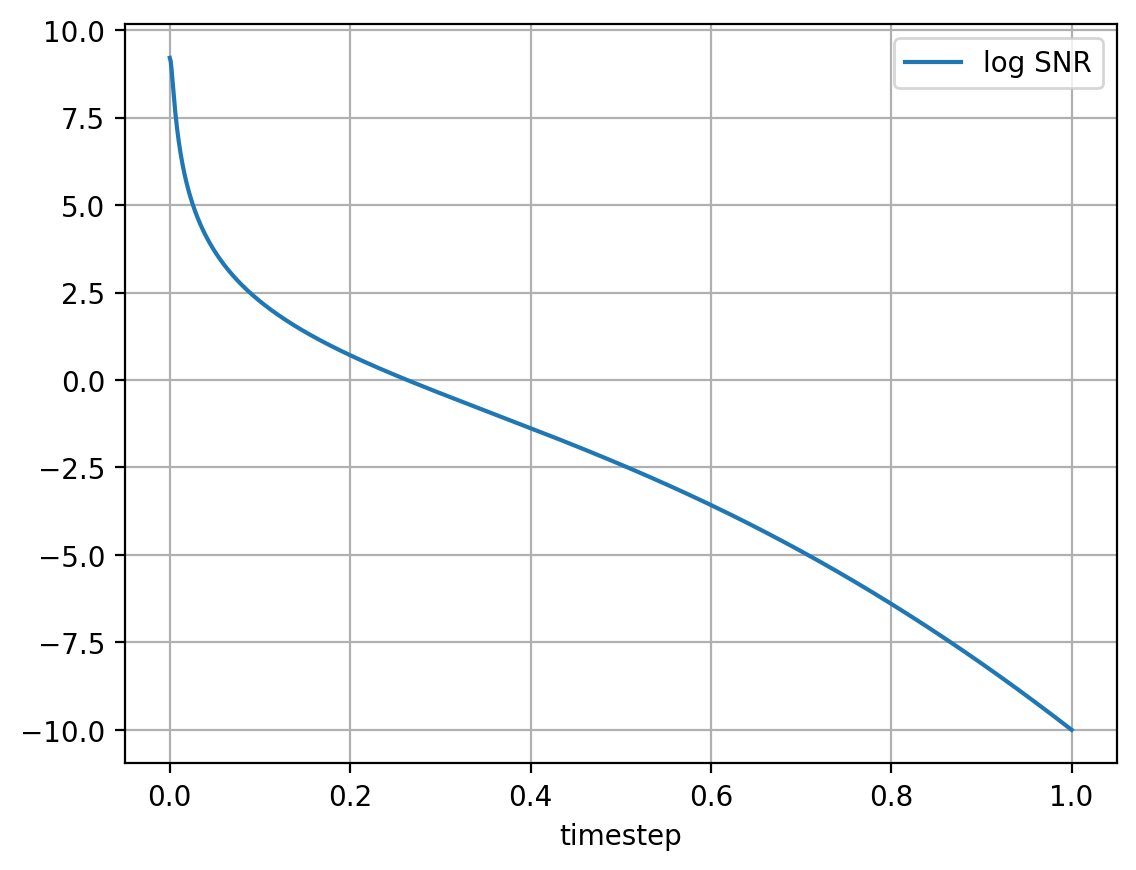

In [7]:
# Visualize the noise schedule

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 100

t_vis = torch.linspace(0, 1, 1000)
log_snrs_vis = get_ddpm_schedule(t_vis)
alphas_vis, sigmas_vis = get_alphas_sigmas(log_snrs_vis)

print('The noise schedule:')

plt.plot(t_vis, alphas_vis, label='alpha (signal level)')
plt.plot(t_vis, sigmas_vis, label='sigma (noise level)')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()

plt.plot(t_vis, log_snrs_vis, label='log SNR')
plt.legend()
plt.xlabel('timestep')
plt.grid()
plt.show()


In [8]:
# Prepare the dataset

batch_size = 100

tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
train_set = datasets.CIFAR10('data', train=True, download=True, transform=tf)
train_dl = data.DataLoader(train_set, batch_size, shuffle=True,
                           num_workers=4, persistent_workers=True, pin_memory=True)
val_set = datasets.CIFAR10('data', train=False, download=True, transform=tf)
val_dl = data.DataLoader(val_set, batch_size,
                         num_workers=4, persistent_workers=True, pin_memory=True)


100%|██████████| 170498071/170498071 [00:12<00:00, 13130694.42it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [9]:
# Create the model and optimizer

seed = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.manual_seed(0)

model = Diffusion().to(device)
model_ema = deepcopy(model)
print('Model parameters:', sum(p.numel() for p in model.parameters()))

opt = optim.Adam(model.parameters(), lr=2e-4)
scaler = torch.cuda.amp.GradScaler()
epoch = 0

# Use a low discrepancy quasi-random sequence to sample uniformly distributed
# timesteps. This considerably reduces the between-batch variance of the loss.
rng = torch.quasirandom.SobolEngine(1, scramble=True)

Using device: cuda
Model parameters: 23211315



Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 0, loss: 0.223988

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

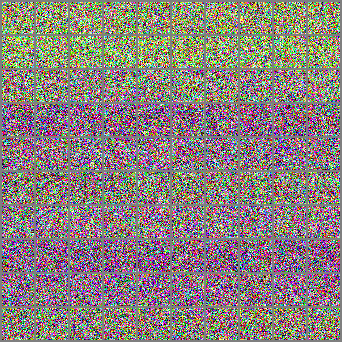


Epoch 0


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 0, iteration: 0, loss: 0.22564
Epoch: 0, iteration: 50, loss: 0.114755
Epoch: 0, iteration: 100, loss: 0.0782047
Epoch: 0, iteration: 150, loss: 0.06724
Epoch: 0, iteration: 200, loss: 0.0607868
Epoch: 0, iteration: 250, loss: 0.0579203
Epoch: 0, iteration: 300, loss: 0.0552624
Epoch: 0, iteration: 350, loss: 0.0546759
Epoch: 0, iteration: 400, loss: 0.0524394
Epoch: 0, iteration: 450, loss: 0.0548942
Epoch 1


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 1, iteration: 0, loss: 0.0607659
Epoch: 1, iteration: 50, loss: 0.050585
Epoch: 1, iteration: 100, loss: 0.0490618
Epoch: 1, iteration: 150, loss: 0.0474496
Epoch: 1, iteration: 200, loss: 0.0467716
Epoch: 1, iteration: 250, loss: 0.0553962
Epoch: 1, iteration: 300, loss: 0.0517045
Epoch: 1, iteration: 350, loss: 0.0539597
Epoch: 1, iteration: 400, loss: 0.0480246
Epoch: 1, iteration: 450, loss: 0.0515377
Epoch 2


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 2, iteration: 0, loss: 0.0458007
Epoch: 2, iteration: 50, loss: 0.0510172
Epoch: 2, iteration: 100, loss: 0.042215
Epoch: 2, iteration: 150, loss: 0.044872
Epoch: 2, iteration: 200, loss: 0.0470663
Epoch: 2, iteration: 250, loss: 0.0499591
Epoch: 2, iteration: 300, loss: 0.0419791
Epoch: 2, iteration: 350, loss: 0.0442377
Epoch: 2, iteration: 400, loss: 0.0437805
Epoch: 2, iteration: 450, loss: 0.0457411
Epoch 3


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 3, iteration: 0, loss: 0.0398742
Epoch: 3, iteration: 50, loss: 0.0462358
Epoch: 3, iteration: 100, loss: 0.0469148
Epoch: 3, iteration: 150, loss: 0.0536584
Epoch: 3, iteration: 200, loss: 0.0462656
Epoch: 3, iteration: 250, loss: 0.0420713
Epoch: 3, iteration: 300, loss: 0.044675
Epoch: 3, iteration: 350, loss: 0.04788
Epoch: 3, iteration: 400, loss: 0.0406591
Epoch: 3, iteration: 450, loss: 0.040687
Epoch 4


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 4, iteration: 0, loss: 0.0414764
Epoch: 4, iteration: 50, loss: 0.0423673
Epoch: 4, iteration: 100, loss: 0.0504096
Epoch: 4, iteration: 150, loss: 0.0415328
Epoch: 4, iteration: 200, loss: 0.0398415
Epoch: 4, iteration: 250, loss: 0.0421337
Epoch: 4, iteration: 300, loss: 0.0384705
Epoch: 4, iteration: 350, loss: 0.0441163
Epoch: 4, iteration: 400, loss: 0.0383008
Epoch: 4, iteration: 450, loss: 0.0449462

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 5, loss: 0.0393256

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

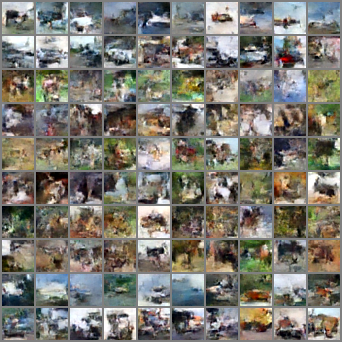


Epoch 5


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 5, iteration: 0, loss: 0.0426571
Epoch: 5, iteration: 50, loss: 0.0429132
Epoch: 5, iteration: 100, loss: 0.0440281
Epoch: 5, iteration: 150, loss: 0.0443071
Epoch: 5, iteration: 200, loss: 0.0363716
Epoch: 5, iteration: 250, loss: 0.0432565
Epoch: 5, iteration: 300, loss: 0.0363678
Epoch: 5, iteration: 350, loss: 0.045993
Epoch: 5, iteration: 400, loss: 0.0444144
Epoch: 5, iteration: 450, loss: 0.0425123
Epoch 6


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 6, iteration: 0, loss: 0.0417804
Epoch: 6, iteration: 50, loss: 0.0394954
Epoch: 6, iteration: 100, loss: 0.0371641
Epoch: 6, iteration: 150, loss: 0.0446977
Epoch: 6, iteration: 200, loss: 0.0439457
Epoch: 6, iteration: 250, loss: 0.044493
Epoch: 6, iteration: 300, loss: 0.0425643
Epoch: 6, iteration: 350, loss: 0.0398692
Epoch: 6, iteration: 400, loss: 0.0429147
Epoch: 6, iteration: 450, loss: 0.0398007
Epoch 7


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 7, iteration: 0, loss: 0.0405659
Epoch: 7, iteration: 50, loss: 0.0414518
Epoch: 7, iteration: 100, loss: 0.0386479
Epoch: 7, iteration: 150, loss: 0.04212
Epoch: 7, iteration: 200, loss: 0.0402578
Epoch: 7, iteration: 250, loss: 0.0368341
Epoch: 7, iteration: 300, loss: 0.039727
Epoch: 7, iteration: 350, loss: 0.038778
Epoch: 7, iteration: 400, loss: 0.037056
Epoch: 7, iteration: 450, loss: 0.0409586
Epoch 8


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 8, iteration: 0, loss: 0.0419262
Epoch: 8, iteration: 50, loss: 0.041624
Epoch: 8, iteration: 100, loss: 0.0401566
Epoch: 8, iteration: 150, loss: 0.0428432
Epoch: 8, iteration: 200, loss: 0.0407546
Epoch: 8, iteration: 250, loss: 0.0415888
Epoch: 8, iteration: 300, loss: 0.0365848
Epoch: 8, iteration: 350, loss: 0.038838
Epoch: 8, iteration: 400, loss: 0.0380561
Epoch: 8, iteration: 450, loss: 0.0449824
Epoch 9


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 9, iteration: 0, loss: 0.0390324
Epoch: 9, iteration: 50, loss: 0.0411361
Epoch: 9, iteration: 100, loss: 0.0352433
Epoch: 9, iteration: 150, loss: 0.0371935
Epoch: 9, iteration: 200, loss: 0.0358968
Epoch: 9, iteration: 250, loss: 0.0427526
Epoch: 9, iteration: 300, loss: 0.0405962
Epoch: 9, iteration: 350, loss: 0.0398456
Epoch: 9, iteration: 400, loss: 0.0392642
Epoch: 9, iteration: 450, loss: 0.0377935

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 10, loss: 0.0369878

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

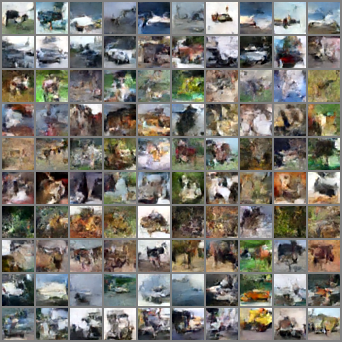


Epoch 10


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 10, iteration: 0, loss: 0.0396219
Epoch: 10, iteration: 50, loss: 0.0372978
Epoch: 10, iteration: 100, loss: 0.0374046
Epoch: 10, iteration: 150, loss: 0.0358665
Epoch: 10, iteration: 200, loss: 0.0371684
Epoch: 10, iteration: 250, loss: 0.0415986
Epoch: 10, iteration: 300, loss: 0.0433653
Epoch: 10, iteration: 350, loss: 0.0333696
Epoch: 10, iteration: 400, loss: 0.0342924
Epoch: 10, iteration: 450, loss: 0.0366609
Epoch 11


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 11, iteration: 0, loss: 0.0371434
Epoch: 11, iteration: 50, loss: 0.0367706
Epoch: 11, iteration: 100, loss: 0.0412242
Epoch: 11, iteration: 150, loss: 0.0438617
Epoch: 11, iteration: 200, loss: 0.0383146
Epoch: 11, iteration: 250, loss: 0.0420471
Epoch: 11, iteration: 300, loss: 0.0359006
Epoch: 11, iteration: 350, loss: 0.0400859
Epoch: 11, iteration: 400, loss: 0.0336029
Epoch: 11, iteration: 450, loss: 0.0368885
Epoch 12


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 12, iteration: 0, loss: 0.0361481
Epoch: 12, iteration: 50, loss: 0.042823
Epoch: 12, iteration: 100, loss: 0.0396843
Epoch: 12, iteration: 150, loss: 0.0403031
Epoch: 12, iteration: 200, loss: 0.0344817
Epoch: 12, iteration: 250, loss: 0.0362747
Epoch: 12, iteration: 300, loss: 0.0360047
Epoch: 12, iteration: 350, loss: 0.0390197
Epoch: 12, iteration: 400, loss: 0.0388775
Epoch: 12, iteration: 450, loss: 0.0404553
Epoch 13


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 13, iteration: 0, loss: 0.040814
Epoch: 13, iteration: 50, loss: 0.0437469
Epoch: 13, iteration: 100, loss: 0.0332009
Epoch: 13, iteration: 150, loss: 0.0373805
Epoch: 13, iteration: 200, loss: 0.0368661
Epoch: 13, iteration: 250, loss: 0.0365344
Epoch: 13, iteration: 300, loss: 0.0404313
Epoch: 13, iteration: 350, loss: 0.0391628
Epoch: 13, iteration: 400, loss: 0.0436316
Epoch: 13, iteration: 450, loss: 0.0368582
Epoch 14


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 14, iteration: 0, loss: 0.0399792
Epoch: 14, iteration: 50, loss: 0.0350804
Epoch: 14, iteration: 100, loss: 0.0323426
Epoch: 14, iteration: 150, loss: 0.0400044
Epoch: 14, iteration: 200, loss: 0.0459967
Epoch: 14, iteration: 250, loss: 0.0408106
Epoch: 14, iteration: 300, loss: 0.039395
Epoch: 14, iteration: 350, loss: 0.0423055
Epoch: 14, iteration: 400, loss: 0.0422061
Epoch: 14, iteration: 450, loss: 0.0373496

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 15, loss: 0.0360205

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

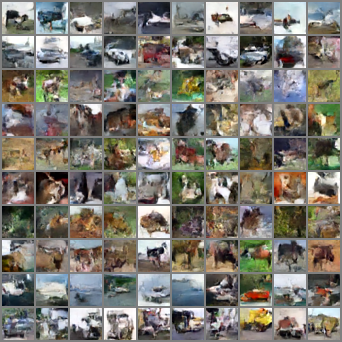


Epoch 15


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 15, iteration: 0, loss: 0.0356135
Epoch: 15, iteration: 50, loss: 0.036203
Epoch: 15, iteration: 100, loss: 0.0347094
Epoch: 15, iteration: 150, loss: 0.0458806
Epoch: 15, iteration: 200, loss: 0.0377762
Epoch: 15, iteration: 250, loss: 0.0379355
Epoch: 15, iteration: 300, loss: 0.0323662
Epoch: 15, iteration: 350, loss: 0.0390655
Epoch: 15, iteration: 400, loss: 0.0370127
Epoch: 15, iteration: 450, loss: 0.0391883
Epoch 16


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 16, iteration: 0, loss: 0.03869
Epoch: 16, iteration: 50, loss: 0.03858
Epoch: 16, iteration: 100, loss: 0.0415829
Epoch: 16, iteration: 150, loss: 0.0411743
Epoch: 16, iteration: 200, loss: 0.0425395
Epoch: 16, iteration: 250, loss: 0.0407333
Epoch: 16, iteration: 300, loss: 0.0361102
Epoch: 16, iteration: 350, loss: 0.0347743
Epoch: 16, iteration: 400, loss: 0.0362044
Epoch: 16, iteration: 450, loss: 0.0379796
Epoch 17


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 17, iteration: 0, loss: 0.0404256
Epoch: 17, iteration: 50, loss: 0.0385543
Epoch: 17, iteration: 100, loss: 0.0388826
Epoch: 17, iteration: 150, loss: 0.036563
Epoch: 17, iteration: 200, loss: 0.0377865
Epoch: 17, iteration: 250, loss: 0.0378818
Epoch: 17, iteration: 300, loss: 0.036487
Epoch: 17, iteration: 350, loss: 0.0432185
Epoch: 17, iteration: 400, loss: 0.038832
Epoch: 17, iteration: 450, loss: 0.0374402
Epoch 18


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 18, iteration: 0, loss: 0.0353183
Epoch: 18, iteration: 50, loss: 0.0405038
Epoch: 18, iteration: 100, loss: 0.0332067
Epoch: 18, iteration: 150, loss: 0.037497
Epoch: 18, iteration: 200, loss: 0.0344454
Epoch: 18, iteration: 250, loss: 0.0425183
Epoch: 18, iteration: 300, loss: 0.0349111
Epoch: 18, iteration: 350, loss: 0.0375697
Epoch: 18, iteration: 400, loss: 0.0352363
Epoch: 18, iteration: 450, loss: 0.0419836
Epoch 19


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 19, iteration: 0, loss: 0.0290693
Epoch: 19, iteration: 50, loss: 0.0376115
Epoch: 19, iteration: 100, loss: 0.0350724
Epoch: 19, iteration: 150, loss: 0.0394589
Epoch: 19, iteration: 200, loss: 0.0418248
Epoch: 19, iteration: 250, loss: 0.0386239
Epoch: 19, iteration: 300, loss: 0.0359471
Epoch: 19, iteration: 350, loss: 0.0345464
Epoch: 19, iteration: 400, loss: 0.035706
Epoch: 19, iteration: 450, loss: 0.0340468

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 20, loss: 0.0354646

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

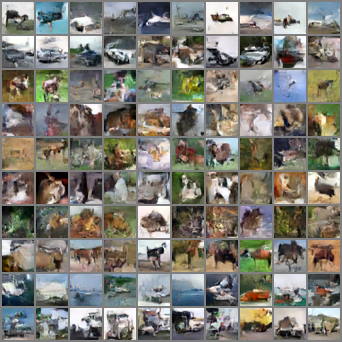


Epoch 20


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 20, iteration: 0, loss: 0.0361496
Epoch: 20, iteration: 50, loss: 0.0363646
Epoch: 20, iteration: 100, loss: 0.0383807
Epoch: 20, iteration: 150, loss: 0.0379907
Epoch: 20, iteration: 200, loss: 0.0378027
Epoch: 20, iteration: 250, loss: 0.0359707
Epoch: 20, iteration: 300, loss: 0.0384686
Epoch: 20, iteration: 350, loss: 0.0395081
Epoch: 20, iteration: 400, loss: 0.0378705
Epoch: 20, iteration: 450, loss: 0.0414422
Epoch 21


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 21, iteration: 0, loss: 0.0391573
Epoch: 21, iteration: 50, loss: 0.040223
Epoch: 21, iteration: 100, loss: 0.0377382
Epoch: 21, iteration: 150, loss: 0.0405043
Epoch: 21, iteration: 200, loss: 0.0318224
Epoch: 21, iteration: 250, loss: 0.0357362
Epoch: 21, iteration: 300, loss: 0.0330011
Epoch: 21, iteration: 350, loss: 0.0376152
Epoch: 21, iteration: 400, loss: 0.0344983
Epoch: 21, iteration: 450, loss: 0.0340182
Epoch 22


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 22, iteration: 0, loss: 0.0356178
Epoch: 22, iteration: 50, loss: 0.0376294
Epoch: 22, iteration: 100, loss: 0.0307503
Epoch: 22, iteration: 150, loss: 0.0390864
Epoch: 22, iteration: 200, loss: 0.036359
Epoch: 22, iteration: 250, loss: 0.0404619
Epoch: 22, iteration: 300, loss: 0.0393056
Epoch: 22, iteration: 350, loss: 0.0359981
Epoch: 22, iteration: 400, loss: 0.0380047
Epoch: 22, iteration: 450, loss: 0.0379461
Epoch 23


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 23, iteration: 0, loss: 0.0342994
Epoch: 23, iteration: 50, loss: 0.0352139
Epoch: 23, iteration: 100, loss: 0.0327435
Epoch: 23, iteration: 150, loss: 0.0383159
Epoch: 23, iteration: 200, loss: 0.0369095
Epoch: 23, iteration: 250, loss: 0.0342972
Epoch: 23, iteration: 300, loss: 0.0389721
Epoch: 23, iteration: 350, loss: 0.033836
Epoch: 23, iteration: 400, loss: 0.0358409
Epoch: 23, iteration: 450, loss: 0.037308
Epoch 24


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 24, iteration: 0, loss: 0.0370714
Epoch: 24, iteration: 50, loss: 0.0389423
Epoch: 24, iteration: 100, loss: 0.0389233
Epoch: 24, iteration: 150, loss: 0.0356263
Epoch: 24, iteration: 200, loss: 0.0361339
Epoch: 24, iteration: 250, loss: 0.0394262
Epoch: 24, iteration: 300, loss: 0.0324201
Epoch: 24, iteration: 350, loss: 0.0376475
Epoch: 24, iteration: 400, loss: 0.0345503
Epoch: 24, iteration: 450, loss: 0.0437541

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 25, loss: 0.0349141

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

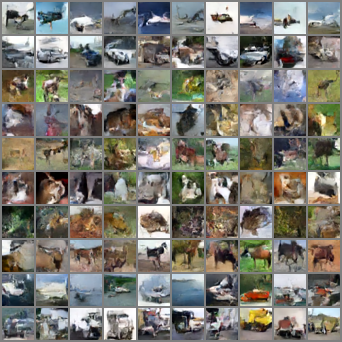


Epoch 25


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 25, iteration: 0, loss: 0.0400228
Epoch: 25, iteration: 50, loss: 0.0361819
Epoch: 25, iteration: 100, loss: 0.0369948
Epoch: 25, iteration: 150, loss: 0.0352307
Epoch: 25, iteration: 200, loss: 0.0326147
Epoch: 25, iteration: 250, loss: 0.0381599
Epoch: 25, iteration: 300, loss: 0.0363232
Epoch: 25, iteration: 350, loss: 0.04318
Epoch: 25, iteration: 400, loss: 0.0436447
Epoch: 25, iteration: 450, loss: 0.0402407
Epoch 26


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 26, iteration: 0, loss: 0.0391645
Epoch: 26, iteration: 50, loss: 0.0411418
Epoch: 26, iteration: 100, loss: 0.0315227
Epoch: 26, iteration: 150, loss: 0.0350644
Epoch: 26, iteration: 200, loss: 0.0372176
Epoch: 26, iteration: 250, loss: 0.0369475
Epoch: 26, iteration: 300, loss: 0.0405754
Epoch: 26, iteration: 350, loss: 0.0317136
Epoch: 26, iteration: 400, loss: 0.0386728
Epoch: 26, iteration: 450, loss: 0.0331103
Epoch 27


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 27, iteration: 0, loss: 0.0347311
Epoch: 27, iteration: 50, loss: 0.037528
Epoch: 27, iteration: 100, loss: 0.0383984
Epoch: 27, iteration: 150, loss: 0.0379983
Epoch: 27, iteration: 200, loss: 0.0361058
Epoch: 27, iteration: 250, loss: 0.0376581
Epoch: 27, iteration: 300, loss: 0.0396065
Epoch: 27, iteration: 350, loss: 0.0364513
Epoch: 27, iteration: 400, loss: 0.0344166
Epoch: 27, iteration: 450, loss: 0.0352148
Epoch 28


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 28, iteration: 0, loss: 0.0306437
Epoch: 28, iteration: 50, loss: 0.0406255
Epoch: 28, iteration: 100, loss: 0.0336687
Epoch: 28, iteration: 150, loss: 0.0358302
Epoch: 28, iteration: 200, loss: 0.032339
Epoch: 28, iteration: 250, loss: 0.0389131
Epoch: 28, iteration: 300, loss: 0.0324307
Epoch: 28, iteration: 350, loss: 0.0375417
Epoch: 28, iteration: 400, loss: 0.037435
Epoch: 28, iteration: 450, loss: 0.0450032
Epoch 29


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch: 29, iteration: 0, loss: 0.0386618
Epoch: 29, iteration: 50, loss: 0.0341945
Epoch: 29, iteration: 100, loss: 0.037218
Epoch: 29, iteration: 150, loss: 0.0443489
Epoch: 29, iteration: 200, loss: 0.0333279
Epoch: 29, iteration: 250, loss: 0.0324458
Epoch: 29, iteration: 300, loss: 0.0357083
Epoch: 29, iteration: 350, loss: 0.0373504
Epoch: 29, iteration: 400, loss: 0.0423187
Epoch: 29, iteration: 450, loss: 0.0341772

Validating...


  0%|          | 0/100 [00:00<?, ?it/s]

Validation: Epoch: 30, loss: 0.0346165

Sampling...


  0%|          | 0/500 [00:00<?, ?it/s]

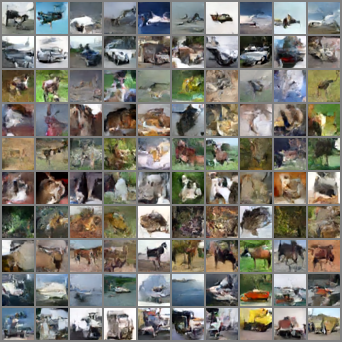

In [10]:
# Actually train the model

ema_decay = 0.998

# The number of timesteps to use when sampling
steps = 500

# The amount of noise to add each timestep when sampling
# 0 = no noise (DDIM)
# 1 = full noise (DDPM)
eta = 1.


def eval_loss(model, rng, reals, classes):
    # Draw uniformly distributed continuous timesteps
    t = rng.draw(reals.shape[0])[:, 0].to(device)

    # Calculate the noise schedule parameters for those timesteps
    log_snrs = get_ddpm_schedule(t)
    alphas, sigmas = get_alphas_sigmas(log_snrs)
    weights = log_snrs.exp() / log_snrs.exp().add(1)

    # Combine the ground truth images and the noise
    alphas = alphas[:, None, None, None]
    sigmas = sigmas[:, None, None, None]
    noise = torch.randn_like(reals)
    noised_reals = reals * alphas + noise * sigmas
    targets = noise * alphas - reals * sigmas

    # Compute the model output and the loss.
    with torch.cuda.amp.autocast():
        v = model(noised_reals, log_snrs, classes)
        return (v - targets).pow(2).mean([1, 2, 3]).mul(weights).mean()


def train():
    for i, (reals, classes) in enumerate(tqdm(train_dl)):
        opt.zero_grad()
        reals = reals.to(device)
        classes = classes.to(device)

        # Evaluate the loss
        loss = eval_loss(model, rng, reals, classes)

        # Do the optimizer step and EMA update
        scaler.scale(loss).backward()
        scaler.step(opt)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        scaler.update()

        if i % 50 == 0:
            tqdm.write(f'Epoch: {epoch}, iteration: {i}, loss: {loss.item():g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def val():
    tqdm.write('\nValidating...')
    torch.manual_seed(seed)
    rng = torch.quasirandom.SobolEngine(1, scramble=True)
    total_loss = 0
    count = 0
    for i, (reals, classes) in enumerate(tqdm(val_dl)):
        reals = reals.to(device)
        classes = classes.to(device)

        loss = eval_loss(model_ema, rng, reals, classes)

        total_loss += loss.item() * len(reals)
        count += len(reals)
    loss = total_loss / count
    tqdm.write(f'Validation: Epoch: {epoch}, loss: {loss:g}')


@torch.no_grad()
@torch.random.fork_rng()
@eval_mode(model_ema)
def demo():
    tqdm.write('\nSampling...')
    torch.manual_seed(seed)

    noise = torch.randn([100, 3, 32, 32], device=device)
    fakes_classes = torch.arange(10, device=device).repeat_interleave(10, 0)
    fakes = sample(model_ema, noise, steps, eta, fakes_classes)

    grid = utils.make_grid(fakes, 10).cpu()
    filename = f'demo_{epoch:05}.png'
    TF.to_pil_image(grid.add(1).div(2).clamp(0, 1)).save(filename)
    display.display(display.Image(filename))
    tqdm.write('')


def save():
    filename = 'cifar_diffusion.pth'
    obj = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'opt': opt.state_dict(),
        'scaler': scaler.state_dict(),
        'epoch': epoch,
    }
    torch.save(obj, filename)


try:
    val()
    demo()
    while True:
        print('Epoch', epoch)
        train()
        epoch += 1
        if epoch % 5 == 0:
            val()
            demo()
        save()
        if epoch == 30:
          break
except KeyboardInterrupt:
    pass
